# CMSE 831 Final Project
### &#9989; Kendall Andrews
#### &#9989; December 5, 2025

# Title: Fantasy Football Roster Optimization with Integer Programming

## Background and Motivation


**Background**: Daily fantasy sports (DFS) lineup construction is a constrained combinatorial problem: choose a small roster from a large player pool subject to a salary cap and position rules. Building optimal lineups requires both good forecasts of player performance and a solver that enforces constraints (positional, salary, team stacking, uniqueness). This project frames lineup selection as a binary ILP (a knapsack-like problem) and compares objective choices (maximize expected points, risk-aware objective) and lineup-generation strategies.

**Motivation**: For fantasy football, one of the main goals is to select the right players for you to outscore your opponent. The goal of my project is to utilize player performance metrics to construct the highest performing team configuration (player metrics given specific positions)

**Question**: Can optimization and injury filtering improve lineup consistency?


## Methodology

#### Methodoloy Outline:
* Constrained Optimization (Inequality Constraints): Modeling full DFS Lineup Construction or Roster Selection problem with salary cap (inequality constraint) and positional requirements (equality/ integer constraints)
* Classification of Optimization Problems (Integer Programming): Integer Linear 
* Program Problem; Binary Problem - deciding based on constraints where its a, 1- starting/on, 0- non-starter/off


NFL Lineup: (Fantasy)
* 9 players: 
    * 1 QB
    * 2 RBs
    * 3 WRs
    * 1 FLEX (RB, WR, TE)
    * 1 TE
    * 1 D/ST

* Constraint: Salary, specific position requirements
* Salary Amount: 50,000
* Goal: satisfy the lineup constrains, while maximizing avg points per game

In [65]:
#%pip install pulp

In [66]:
#importing pandas is a Python library for working with datasets
import pandas as pd
#numpy - Python library - np: numerical python
import numpy as np
#matplotlip.pyplot -  a collection of functions that allows you to make plots like MATLAB using Python
import matplotlib.pyplot as plt
#Python data visualization library based on matplotlib
import seaborn as sns
#plotly express library for interactive plots and visualizations
import plotly.express as px
#importing xg boost
import xgboost as xgb
#importing PuLP - an linear and mixed integer programming modeler written in Python
import pulp
#imports re module, regular expressions for find and replace operations, data validation, and text parsing.
import re
#import permutations used to generate all possible ordered arrangements (permutations) of a given iterable (like a list, string, or tuple
from itertools import permutations
#import used to bring all public names (functions, classes, variables, etc.) from the pulp library directly into the current namespace
from pulp import *

#Get the data
df = pd.read_csv("~/Downloads/DFF_NFL_cheatsheet_2025-11-06.csv")
df

,first_name,last_name,position,injury_status,week,game_date,slate,team,opp,spread,...,implied_team_score,salary,L5_dvp_rank,L5_fppg_avg,L10_fppg_avg,szn_fppg_avg,ppg_projection,value_projection,ppg_actual,value_actual
0,Christian,McCaffrey,RB,NaN,10,2025-11-09,Thu-Mon,SF,LAR,4.5,...,22.5,9000,1,28.2,24.6,26.4,24.4,2.71,NaN,NaN
1,Jaxon,Smith-Njigba,WR,NaN,10,2025-11-09,Thu-Mon,SEA,ARI,-6.5,...,26.0,8600,18,26.1,20.8,24.5,23.3,2.71,NaN,NaN
2,Josh,Allen,QB,NaN,10,2025-11-09,Thu-Mon,BUF,MIA,-9.5,...,29.5,7000,23,23.3,23.4,24.3,22.7,3.25,NaN,NaN
3,Lamar,Jackson,QB,NaN,10,2025-11-09,Thu-Mon,BAL,MIN,-4.5,...,27.0,6800,13,24.2,23.8,24.2,21.8,3.21,NaN,NaN
4,Jonathan,Taylor,RB,NaN,10,2025-11-09,Thu-Mon,IND,ATL,-6.5,...,27.5,9500,23,28.1,26.4,26.3,21.7,2.28,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356,Deshaun,Watson,QB,O,10,2025-11-09,Thu-Mon,CLE,NYJ,-2.5,...,20.5,4000,21,10.5,11.6,NaN,0.0,0.00,NaN,NaN
357,Irvin,Charles,WR,O,10,2025-11-09,Thu-Mon,NYJ,CLE,2.5,...,18.0,3000,16,0.0,0.0,NaN,0.0,0.00,NaN,NaN
358,Brandon,Aiyuk,WR,O,10,2025-11-09,Thu-Mon,SF,LAR,4.5,...,22.5,4800,20,10.5,9.5,NaN,0.0,0.00,NaN,NaN
359,Kurtis,Rourke,QB,O,10,2025-11-09,Thu-Mon,SF,LAR,4.5,...,22.5,4000,7,NaN,NaN,NaN,0.0,0.00,NaN,NaN


### Data Preprocessing

Text(0.5, 1.0, 'Heatmap of Missingness')

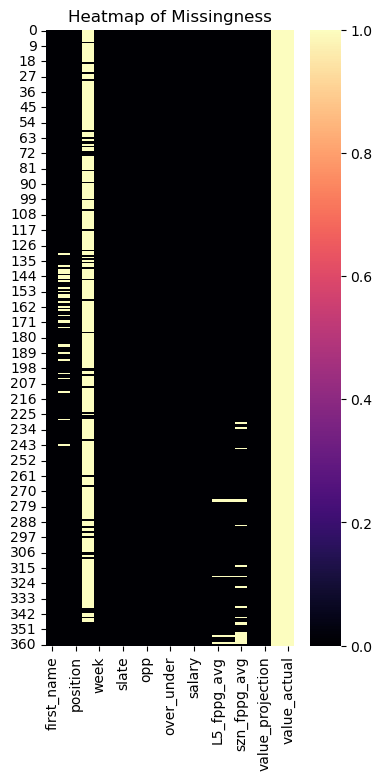

In [67]:
#Visualize the missingness 
plt.figure(figsize=(4,8))
sns.heatmap(df.isna(), cmap="magma")
plt.title("Heatmap of Missingness")

In [68]:
print(df.isna().sum())

first_name              0
last_name              28
position                0
injury_status         301
week                    0
game_date               0
slate                   0
team                    0
opp                     0
spread                  0
over_under              0
implied_team_score      0
salary                  0
L5_dvp_rank             0
L5_fppg_avg             5
L10_fppg_avg            5
szn_fppg_avg           20
ppg_projection          0
value_projection        0
ppg_actual            361
value_actual          361
dtype: int64


In [69]:
#looking for duplicates
duplicate_rows = df.duplicated()
for i in duplicate_rows:
    if i == True:
        print(duplicate_rows)
    else:
        pass

In [70]:
#outlier detection
from scipy import stats

def find_outliers_df(df):
    outlier_data = []  # List to store results
    
    for column in df.select_dtypes(include=[np.number]).columns:  # Loop through numerical columns
        z = np.abs(stats.zscore(df[column].dropna()))  # Calculate Z-score
        threshold = 3
        num_outliers = np.sum(z > threshold)  # Count outliers

        outlier_data.append({"Column": column, "Outliers Count": num_outliers})  # Append to list

    # Convert to DataFrame
    outlier_df = pd.DataFrame(outlier_data)
    
    return outlier_df  # Return the DataFrame

# Get outlier DataFrame and display it
outlier_df = find_outliers_df(df)
outlier_df

,Column,Outliers Count
0,week,0
1,spread,0
2,over_under,0
3,implied_team_score,0
4,salary,5
5,L5_dvp_rank,0
6,L5_fppg_avg,2
7,L10_fppg_avg,1
8,szn_fppg_avg,2
9,ppg_projection,1


Text(0.5, 1.0, 'Correlation Heatmap')

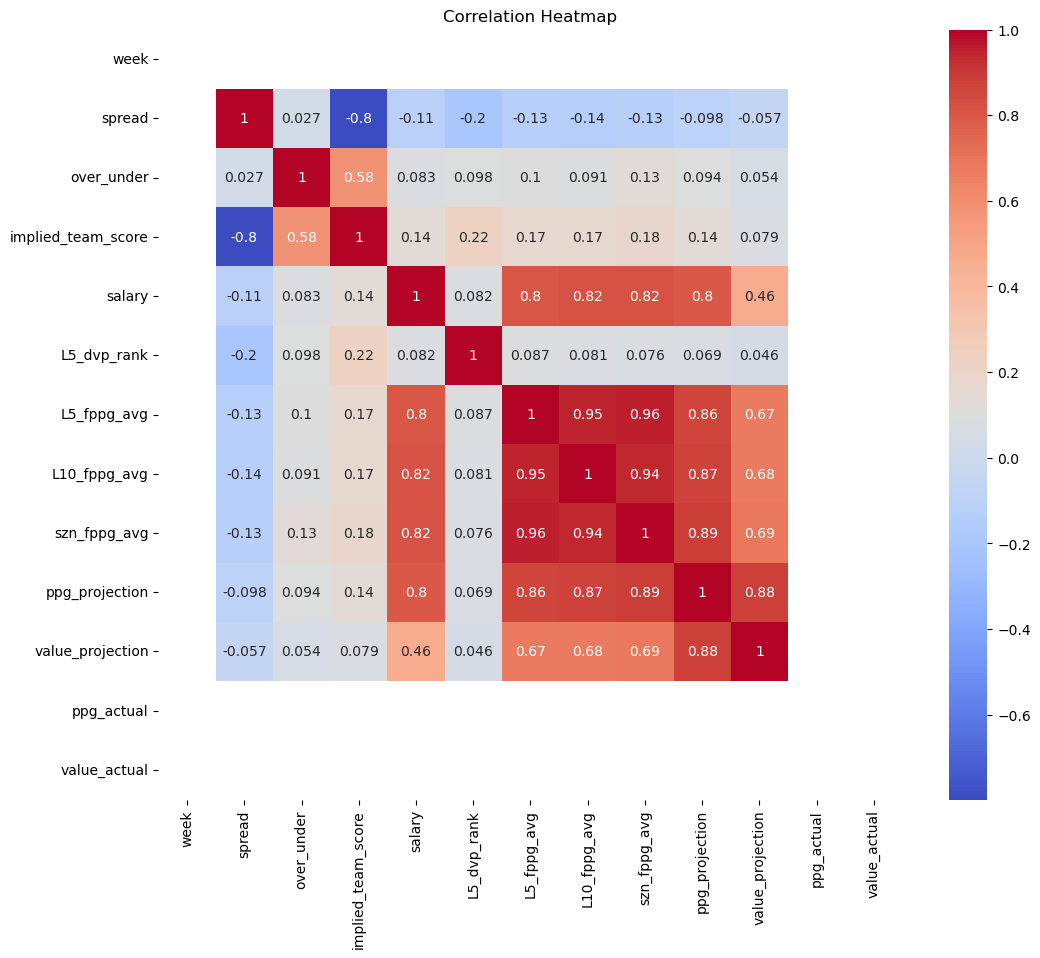

In [71]:
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')

This correlation map shows that beside the variables that would obviously be correlated to one another (L5_fppg_avg, L10_fppg_avg, szn_fppg_avg). The constraints (salary and and points per game are highly correlated as well)

In [72]:
df_dtypes = df.dtypes.reset_index()
df_dtypes.columns = ["Column", "Data Type"]
df_dtypes

,Column,Data Type
0,first_name,object
1,last_name,object
2,position,object
3,injury_status,object
4,week,int64
5,game_date,object
6,slate,object
7,team,object
8,opp,object
9,spread,float64


* first_name (obj): first name
* last_name (obj): last name
* position (obj): player position (between 6)
* injury_status (obj): injury status of the player (empty, Q - questionable, O - out)
* week (int): what week the game is players
* game_date (obj): date of the players game this week
* slate (obj): the span the games are played (Thu-Mon - all)
* team (obj): what team the player is on
* opp (obj): what opposing team the player plays this week
* spread (float): # that determines the gap between the favorite or the underdog of the game
* over_under (float): projected total points the team will score in a game
* implied_team_score (float): projected final score of the team
* salary (int): the players salary
* L5_dvp_rank (int): last 5 defense per position rank
* L5_fppg_avg (float): last 5 average fantasy points per game
* L10_fppg_avg (float): last 10 average fantasy points per game
* szn_fppg_avg (float): seasons average fantasy points per game 
* ppg_projection (float): points per game projection
* value_projection (float): value projection (player projections vs. cost)
* ppg_actual (float): actual points per game projection (empty)
* value_actual (float): actual value (empty)

In [73]:
# remove players that are questionable
df = df[~df['injury_status'].isin(['Q', 'O', 'D', 'IR'])]
#Q - questionable
#O - out
#D - doubtful
#IR - injured reserved 

#merge first and last name
#defense doesn't have a last name, add empty space in order to merge
df['last_name'] = df['last_name'].fillna('')
df['name'] = df['first_name'] + ' ' + df['last_name']

#drop columns not needed
columns_to_drop = [
    'first_name', #merging
    "last_name", #merging
    "week", # only using one week
    "game_date",  # not used in constraint
    "slate",  # not using multiple slates
    "opp",  # not used in projection-based optimization
    "spread", # not used unless modeling Vegas-based expected value
    "total",  # not used unless modeling Vegas-based expected value
    "implied_team_score",  # not needed unless creating your own projection model
    #"L5_dvp_rank",  #not needed unless adding matchup adjustments
    #"L5_fppg_avg",  # not required — projections already summarize this
    #"L10_fppg_avg", # not required — projections already summarize this
    "szn_fppg_avg",  # not required — projections already summarize this
    "value_projection",  # not needed; solver directly optimizes projection
    "ppg_actual",  # only needed for backtesting, not optimization
    "value_actual"  # only needed for backtesting, not optimization
]

df_new = df.drop(columns=columns_to_drop, errors="ignore")
#df_new[df_new.position == "DST"]
df_new

/var/folders/zz/3b4b_cj17rgb4t357254xqqc0000gp/T/ipykernel_90579/2499506145.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/zz/3b4b_cj17rgb4t357254xqqc0000gp/T/ipykernel_90579/2499506145.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,position,injury_status,team,over_under,salary,L5_dvp_rank,L5_fppg_avg,L10_fppg_avg,ppg_projection,name
0,RB,NaN,SF,49.5,9000,1,28.2,24.6,24.4,Christian McCaffrey
1,WR,NaN,SEA,45.5,8600,18,26.1,20.8,23.3,Jaxon Smith-Njigba
2,QB,NaN,BUF,49.5,7000,23,23.3,23.4,22.7,Josh Allen
3,QB,NaN,BAL,49.5,6800,13,24.2,23.8,21.8,Lamar Jackson
4,RB,NaN,IND,48.5,9500,23,28.1,26.4,21.7,Jonathan Taylor
...,...,...,...,...,...,...,...,...,...,...
338,RB,NaN,BAL,49.5,4000,14,0.5,0.4,0.3,Patrick Ricard
342,WR,NaN,LV,42.5,3000,3,0.4,0.9,0.2,Alex Bachman
343,WR,NaN,JAX,37.5,3200,4,3.3,2.5,0.1,Tim Patrick
345,WR,NaN,SEA,45.5,3100,18,3.9,3.6,0.1,Cody White


In [74]:
#Calculating the standard deviation of players historical weekly scores to produce a proxy risk metric
#don't hae individual weeks of values to do stdev, but can get the voaltility metric with L10_fppg_avg and L5_fppg_avg

#Volatility Metric = absolute difference between L10_fppg_avg and L5_fppg_avg
#A larger difference indicates higher short-term volatility (high volatility suggest recent change in performance which can be pos or neg)
df_new['Volatility_Metric'] = abs(df_new['L5_fppg_avg'] - df_new['L10_fppg_avg'])

# Create the master dictionary for the new risk metric
risk_master = df_new.set_index('name')['Volatility_Metric'].to_dict()

In [75]:
#Group by columns need: position, name, salary, points
availables = df_new[["position", "name", "salary",
  "ppg_projection"]].groupby(["position", "name", "salary",
  "ppg_projection"]).agg("count")
availables = availables.reset_index()
availables[availables.position=="DST"].head(15)
#availables

,position,name,salary,ppg_projection
0,DST,49ers,2700,4.8
1,DST,Bears,3000,7.0
2,DST,Bills,3700,7.1
3,DST,Broncos,3500,7.9
4,DST,Browns,2900,6.6
5,DST,Buccaneers,2700,6.9
6,DST,Cardinals,2200,5.6
7,DST,Chargers,3300,7.0
8,DST,Colts,3400,7.2
9,DST,Commanders,2100,4.2


### Linear Programming Constraints

In [76]:
#Creating LP Constraints (salary, points, player positions)

#a dictionary for all unique players across all positions
all_players = availables["name"].unique()
#print(all_players)

#a dictionary mapping player name to salary
salaries = availables.set_index('name')['salary'].to_dict()
#print(salaries)

#a dictionary mapping player name to points, for 
points_master = availables.set_index('name')['ppg_projection'].to_dict()
#print(points_master)

#a dictionary for which positions each player is eligible for
eligibility = {
    row['name']: row['position'] 
    for index, row in availables.iterrows()
}
#print(eligibility)

# Define the positional requirements, for LP constraints
position_requirements = {
    "QB": 1,
    "RB": 2, # or 3
    "WR": 3, # or 2
    "TE": 1,
    "DST": 1,
    "FLEX": 1 # We will enforce this separately
}


### Integer Linear Programming Formulation:
1. X_p: Binary variable for each unique player p (1= Yes/Selected, 0= No/Not Selected)
2. Y_p,pos: Binary variable for each player p assigned to a position pos (1= Yes/Selected, 0= No/Not Selected)

$$
\sum_{p\epsilon Players} Points_p * x_p
$$

Subject to:
1. Salary Cap: $$ \sum_{p\epsilon Players} Salary_p * x_p <= 50000$$
2. Total Roster Size: $$ \sum_{p\epsilon Players} x_p = 9 (1 QB, 2 RB, 3 WR, 1 TE, 1 DST, 1 FLEX)$$
3. One Player per Position Slot:  $$ \sum_{p\epsilon Players} Y_{p,pos} = Requirement_{pos}$$
    * For QB, RB, WR, TE, DST
    * Define FLEX: The sum of players assigned to the FLEX-eligible positions (RB, WR, TE) must be one more than the fixed requirements:
    * (YRB + YWR + YTE) = (2 + 3 + 1) + 1 = 7
4. No Double Counting (The Key Constraint): 
    * A player p can only be selected once: 
    x_p = $$\sum_{pos} Y_{p,pos}$$ (where the sum is over all positions p is eligible for)

### Integer Linear Program with PuLP

In [77]:
#A single set of binary variables for all unique players, and then define the positional sets based on player eligibility.

# Create the linear programming problem
#LpProblem - Container class for a Linear or Integer programming problem
#LpMaximize - maximizing your team's total projected points
prob = LpProblem("FantasyFootballOptimization", LpMaximize)

# 1. Define one set of binary variables for all unique players

# Create a dictionary of a binary variable where the keys are the player names and values are the binary variables
# Ex: Jayden Daniels: 1
#(xp)
player_binary = LpVariable.dict("Player", all_players, cat="Binary")

# 2. Objective: Maximize total points
#(Summation of p in players)) = Points_p * x_p

#lpSum - gives a list (a1*x1, a2*x2,...an*xn) to construct a linear expression for a constraint or variable
#Creating total fantasy points by multiplying the players points with the player's binary value of (0 or 1)
    #If the player is starting(1), their total fantasy points would be created
    #If the player is not starting(0), points * 0 = 0
#with list comprehension of players 
prob += (
    lpSum(points_master[p] * player_binary[p] for p in all_players),
    "Total_Fantasy_Points"
)

# 3. Constraint: Salary Cap
#(Summation of p in players) = Salary_p * x_p <= 50000

#Creating salary cap by multiplying the players salary with the player's binary value of (0 or 1)
#Creating the salary cap constraint by making sure the salary is less than or equal to 50,000
    #If the player is starting(1), their salary would be created
    #If the player is not starting(0), salary cap * 0 = 0
#with list comprehension of players
prob += (
    lpSum(salaries[p] * player_binary[p] for p in all_players) <= 50000,
    "Salary_Cap_Constraint"
)

# 4. Constraint: Roster Size (Must select exactly 9 players)
#(Summation of p in players) = x_p = 9 (1 QB, 2 RB, 3 WR, 1 TE, 1 DST, 1 FLEX)

#Creating roster by summing the binary values (0,1) assigned to each player variable.
#Creating the roster size constraint by making sure the roster equals 9
    #If the player is starting(1), roster = (1 * num of players (9))
    #If the player is not starting(0), roster (0 * num of players)
#with list comprehension of players
prob += (
    lpSum(player_binary[p] for p in all_players) == 9,
    "Roster_Size_Constraint"
)

# 5. Constraint: Positional Requirements (RB, WR, TE, DST, and QB)
#(Summation of p in players) = Y_{p,pos} = Requirement_{pos}

#Check if the selected player is eligible for the position
#Define the required positions (QB, RB, WR, TE, DST) + 1 FLEX player

#Create sets of players eligible for each slot (FLEX is RBs, WRs, TEs)
#with list comprehension for if the players are eligible
QB_players = [p for p in all_players if eligibility[p] == "QB"]
RB_players = [p for p in all_players if eligibility[p] == "RB"]
WR_players = [p for p in all_players if eligibility[p] == "WR"]
TE_players = [p for p in all_players if eligibility[p] == "TE"]
DST_players = [p for p in all_players if eligibility[p] == "DST"]

# Add the hard positional requirements (QB, DST, and min/max for the others)

#There must be only 1 QB on the roster
prob += lpSum(player_binary[p] for p in QB_players) == 1, "QB_Constraint"
#There must be only 1 DST on the roster
prob += lpSum(player_binary[p] for p in DST_players) == 1, "DST_Constraint"

# RBs: must select at least 2
prob += lpSum(player_binary[p] for p in RB_players) >= 2, "RB_Min_Constraint"
# WRs: must select at least 3
prob += lpSum(player_binary[p] for p in WR_players) >= 3, "WR_Min_Constraint"
# TEs: must select at least 1
prob += lpSum(player_binary[p] for p in TE_players) >= 1, "TE_Min_Constraint"


# 6. Constraint: FLEX
#The only players eligible to be FLEX players are RBs, WRs, and TEs
FLEX_eligible_players = RB_players + WR_players + TE_players
#The total number of selected RB, WR, and TE players = 7
#Already enforced the minimums (2+3+1 = 6), this forces one more selection (FLEX)
prob += lpSum(player_binary[p] for p in FLEX_eligible_players) == 7, "FLEX_Constraint"

# Solve the problem
prob.solve()

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/anaconda3/lib/python3.12/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/zz/3b4b_cj17rgb4t357254xqqc0000gp/T/75593b074c704f709577b47008d4282b-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/zz/3b4b_cj17rgb4t357254xqqc0000gp/T/75593b074c704f709577b47008d4282b-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 13 COLUMNS
At line 2065 RHS
At line 2074 BOUNDS
At line 2376 ENDATA
Problem MODEL has 8 rows, 301 columns and 1148 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 142.868 - 0.00 seconds
Cgl0004I processed model has 8 rows, 279 columns (279 integer (273 of which binary)) and 1074 elements
Cutoff increment increased from 1e-05 to 0.0999
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.92
Cbc0038I Pass   1: suminf.    0.82143 (

1

In [78]:
def summary(prob, player_binary, eligibility, points_master, salaries):
    div = '---------------------------------------\n'
    
    # Roster Requirements for calculation
    pos_reqs = {"RB": 2, "WR": 3, "TE": 1}
    
    selected_roster = []
    
    # 1. Get all selected players and their details

    #looping through all players with binary values
    for p in player_binary:
        #if players binary val = 1
        if player_binary[p].varValue == 1.0:
            #show players eligibility, position
            position = eligibility[p]
            #add to roster
            selected_roster.append({
                "Player": p,
                "Position": position,
                "Salary": salaries[p],
                "Points": points_master[p]
            }) 
    #create roster as a df       
    roster_df = pd.DataFrame(selected_roster)
    
    # 2. Identify the FLEX player among RB/WR/TE
    #add all players from roster who are RB, WR, and TE to flex df
    flex_eligible_df = roster_df[roster_df['Position'].isin(['RB', 'WR', 'TE'])].copy()
    #get counts of selected players for these positions
    pos_counts = flex_eligible_df['Position'].value_counts().to_dict()
    
    #3. Identify players not selected (excess)
    excess_players = []
    for pos, count in pos_counts.items():
        #position requirements, pos = RB, WR, TE and count(binary value) = 0
        required = pos_reqs.get(pos, 0)
        excess_count = count - required
        
        if excess_count > 0:
            #sort players by points (ascending) to find the best FLEX player
            excess_candidates = flex_eligible_df[flex_eligible_df['Position'] == pos].sort_values(by='Points', ascending=True)
            
            #Add the lowest-scoring (from roster - RB, WR, TE slection) to 'excess_count' number of players to the list
            #.head() takes the player at the top of the excess count - highest scoring ploayer
            excess_players.extend(excess_candidates['Player'].head(excess_count).tolist())

    #Make sure to label one player as FLEX 
    if excess_players:
        #Find the single lowest scoring player among all players in excess_players list
        flex_player_name = roster_df[roster_df['Player'].isin(excess_players)].sort_values(by='Points', ascending=True)['Player'].iloc[0]
        
        #Label the FLEX player
        roster_df.loc[roster_df['Player'] == flex_player_name, 'Position'] = 'FLEX (' + roster_df['Position'] + ')'
        
        #Now, remove the original position from the FLEX-eligible candidates
        #to ensure the sorting below is correct (e.g., TE -> FLEX)
        
    # 4. Sort and display the final roster
    position_order_map = {
    'QB': 1,
    'RB': 2,    # First RB (will sort by points for the second RB)
    'WR': 3,
    'FLEX (RB)': 4,
    'FLEX (WR)': 4,
    'FLEX (TE)': 4,
    'TE': 5,
    'DST': 6
}
    #Sort position based on position order map
    roster_df['Sort_Rank'] = roster_df['Position'].map(position_order_map)
    # Sort by the rank first, original position, then points (descending)
    roster_df = roster_df.sort_values(
        by=['Sort_Rank', 'Position', 'Points'], 
        ascending=[True, False, False]
    )
    #Drop the temporary rank column before printing
    roster_df = roster_df.drop(columns=['Sort_Rank'])

    # --- METRICS  ---
    # Calculate and print metrics (optional but good practice)
    total_points = roster_df['Points'].sum()
    total_salary = roster_df['Salary'].sum()
    
    print("\n---------------------------------------")
    print("Metrics:")
    print(f"Total Projected Points: {total_points:,.2f}")
    print(f"Total Salary Used: ${total_salary:,.0f} out of $50,000")
    print("---------------------------------------\n")
    
    return roster_df
    #print("| Roster |")
    #print("----------\n")
    #print(roster_df.to_markdown(index=False))
    
final_roster_df = summary(prob, player_binary, eligibility, points_master, salaries)
final_roster_df


---------------------------------------
Metrics:
Total Projected Points: 142.30
Total Salary Used: $50,000 out of $50,000
---------------------------------------



,Player,Position,Salary,Points
1,Jaxson Dart,QB,5700,20.2
2,Christian McCaffrey,RB,9000,24.4
3,De'Von Achane,RB,7400,21.6
6,Jaxon Smith-Njigba,WR,8600,23.3
7,Khalil Shakir,WR,5100,13.4
8,Olamide Zaccheaus,WR,3600,9.1
5,Hunter Henry,FLEX (TE),3500,9.8
4,George Kittle,TE,4500,12.9
0,Jaguars,DST,2600,7.6


PRINT PLAYERS ACTUAL VALUES IF POSSIBLE...

## Results

In [79]:
final_roster_df

,Player,Position,Salary,Points
1,Jaxson Dart,QB,5700,20.2
2,Christian McCaffrey,RB,9000,24.4
3,De'Von Achane,RB,7400,21.6
6,Jaxon Smith-Njigba,WR,8600,23.3
7,Khalil Shakir,WR,5100,13.4
8,Olamide Zaccheaus,WR,3600,9.1
5,Hunter Henry,FLEX (TE),3500,9.8
4,George Kittle,TE,4500,12.9
0,Jaguars,DST,2600,7.6


In [80]:
# 1. Create the DataFrame
data = {
    'Player': ['Jaxson Dart', 'Christian McCaffrey', 'De\'Von Achane', 'Jaxon Smith-Njigba', 
               'Khalil Shakir', 'Olamide Zaccheaus', 'Hunter Henry', 'George Kittle', 'Jaguars'],
    'Position': ['QB', 'RB', 'RB', 'WR', 'WR', 'WR', 'FLEX (TE)', 'TE', 'DST'],
    'Projected Points': [20.2, 24.4, 21.6, 23.3, 13.4, 9.1, 9.8, 12.9, 7.6],
    'Actual Points': [26.28, 17.6, 44.0, 21.3, 12.8, 1.5, 1.9, 23.4, 8.0]
}

print("\n---------------------------------------")
print("Metrics:")
print(f"Total Projected Points: 142.30")
print(f"Total Actual Points 156.78")
print("---------------------------------------\n")
results_df = pd.DataFrame(data)
results_df

#Data for ESPN Fanstasy Mobile


---------------------------------------
Metrics:
Total Projected Points: 142.30
Total Actual Points 156.78
---------------------------------------



,Player,Position,Projected Points,Actual Points
0,Jaxson Dart,QB,20.2,26.28
1,Christian McCaffrey,RB,24.4,17.60
2,De'Von Achane,RB,21.6,44.00
3,Jaxon Smith-Njigba,WR,23.3,21.30
4,Khalil Shakir,WR,13.4,12.80
5,Olamide Zaccheaus,WR,9.1,1.50
6,Hunter Henry,FLEX (TE),9.8,1.90
7,George Kittle,TE,12.9,23.40
8,Jaguars,DST,7.6,8.00


The final difference between the total projected points and total actual points = 14.48

#### Scatter Plot: Projected vs. Actual Points


In [81]:
#1. Calculate the Error
results_df['Difference'] = round(results_df['Actual Points'] - results_df['Projected Points'], 2)
results_df['Abs_Difference'] = round(results_df['Difference'].abs(), 2)

# 2. Scatter Plot
fig = px.scatter(
    results_df,
    x="Projected Points",
    y="Actual Points",
    color="Position", 
    size="Abs_Difference", # Size the points by the magnitude of the error
    
    hover_data=['Player', 'Position', 'Projected Points', 'Actual Points', 'Difference'],
    title="Actual vs. Projected Points (Week 10 Roster)"
)

# 3. Add the Line of Perfect Agreement (Y = X)
#Points above the line: Players who Overperformed (Actual > Projected)
#Points below the line: Players who Underperformed (Actual < Projected)
max_val = max(results_df['Projected Points'].max(), results_df['Actual Points'].max())
fig.add_shape(
    type='line',
    x0=0, y0=0,
    x1=max_val * 1.05, y1=max_val * 1.05,
    line=dict(color='Red', width=2, dash='dash')
)

fig.update_layout(
    xaxis_title="Projected Points (X)",
    yaxis_title="Actual Points (Y)",
    # Ensure axes are equally scaled for the diagonal line to work correctly
    xaxis_range=[0, max_val * 1.1],
    yaxis_range=[0, max_val * 1.1]
)

fig.show()

* The players who performed above their projected points  (large dots) are justifiable optimal players as they are above the league-wide trendline and their selection represents the best "points per dollar" value.
* Most players scored below their projected points than above. 
* The biggest boom player (far above the line) = De'Von Achane - RB (44 pts, 21.6 projected, 22.4 difference)
* The biggest bust player (far below the line)= Hunter Henry- FLEX (1.9 pts, 9.8 projected, 7.9 difference)
* These results are due to unpredictable variance, which is a limitation of all projection-based models

#### Bar Plot: Projected Points by Player

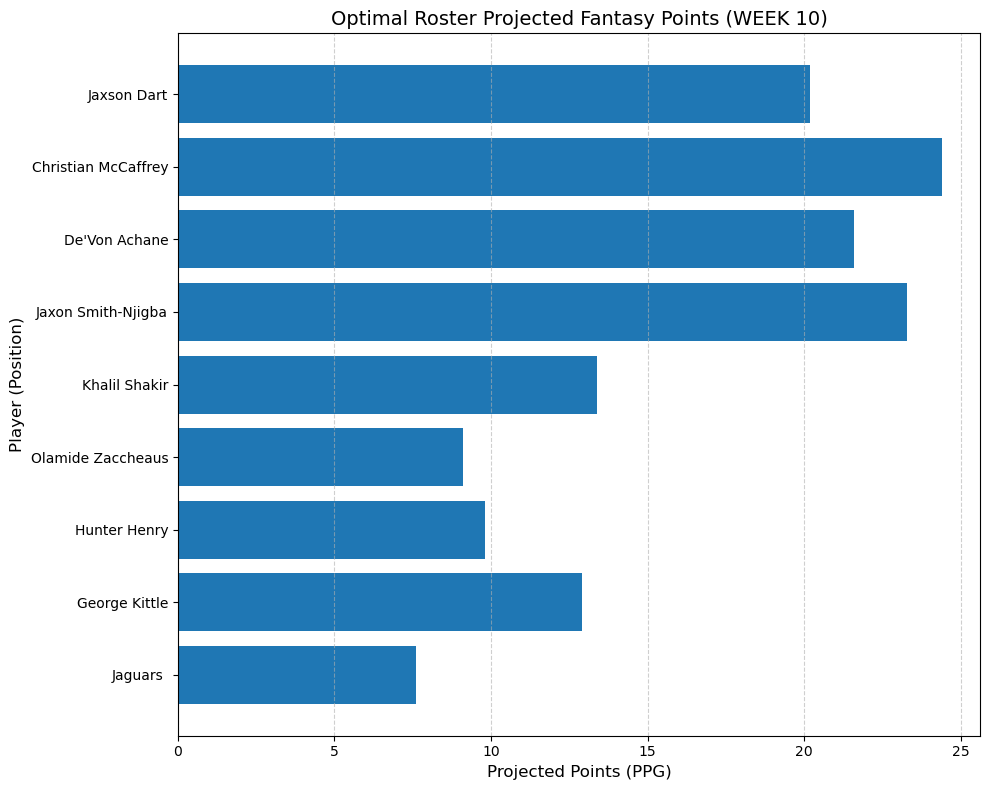

In [82]:
# Bar Chart of Projected Points by Player
plt.figure(figsize=(10,8))
# Use barh for a horizontal bar chart: plt.barh(y, width)
plt.barh(final_roster_df['Player'], final_roster_df['Points'])

# Invert the y-axis so that the order (QB -> DST) is top-to-bottom on the plot
plt.gca().invert_yaxis()

plt.title('Optimal Roster Projected Fantasy Points (WEEK 10)', fontsize=14)
plt.xlabel('Projected Points (PPG)', fontsize=12)
plt.ylabel('Player (Position)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

#### Scatter Plot: Salary vs. Projected Points (Constraints)

In [88]:
fig = px.scatter(
    final_roster_df,
    x="Salary",
    y="Points",
    color="Position",
    #data when hover over the point
    hover_data=['Player', 'Position', 'Points', 'Salary'],
    title="Salary vs. Projected Points"
)


fig.update_traces(
    marker=dict(size=10, line=dict(width=1, color='DarkSlateGrey')),
    selector=dict(mode='markers')
)
fig.show()

My optimal players are in the top 4 spots (Christian McCaffrey, Jaxon Smith-Njigba, De'Von Achane, Jaxson Dart), where they are all projected to score higher than 20 points and they are also the most expensive players on the roster. (2 RBs, WR, QB)

#### Scatter plot: Risk vs. Reward (Uncertainty Analysis)

In [84]:
player_names = final_roster_df['Player'].values
player_points = final_roster_df['Points'].values

for player_name, player_points in zip(player_names, player_points):
    # Look up the Volatility Metric using the dictionary
    risk_value = risk_master.get(player_name, 0.0)
    
    print(f"{player_name}: {player_points:.2f} points, {risk_value:.2f} Volatility")

#Plot risk vs. reward

#Create a new column for volatility by mapping the player names to the risk_master dictionary.
final_roster_df['Volatility'] = final_roster_df['Player'].map(risk_master)

fig = px.scatter(
    final_roster_df,
    x="Points", # Reward
    y="Volatility", # Risk
    color="Position",
    hover_data=['Player', 'Position', 'Points', 'Salary', 'Volatility'],
    title="Volatility (Risk) vs. Projected Points (Reward)" # Updated Title
)

fig.update_traces(
    marker=dict(size=10, line=dict(width=1, color='DarkSlateGrey')),
    selector=dict(mode='markers')
)

#Add annotations for interpretation
fig.add_annotation(
    x=final_roster_df['Points'].max(), y=final_roster_df['Volatility'].max(),
    text="High Reward, High Risk", showarrow=False, bgcolor="#FFDDDD", opacity=0.8,
    font=dict(color="red", size=10)
)
fig.add_annotation(
    x=final_roster_df['Points'].min(), y=final_roster_df['Volatility'].min(),
    text="Low Reward, Low Risk (High Floor)", showarrow=False, bgcolor="#DDFFDD", opacity=0.8,
    font=dict(color="green", size=10)
)
fig.update_layout(
    yaxis_title="Volatility (Risk)",
    xaxis_title="Projected Points (Reward)"
)

fig.show()

Jaxson Dart: 20.20 points, 6.40 Volatility
Christian McCaffrey: 24.40 points, 3.60 Volatility
De'Von Achane: 21.60 points, 0.30 Volatility
Jaxon Smith-Njigba: 23.30 points, 5.30 Volatility
Khalil Shakir: 13.40 points, 1.10 Volatility
Olamide Zaccheaus: 9.10 points, 1.40 Volatility
Hunter Henry: 9.80 points, 1.70 Volatility
George Kittle: 12.90 points, 4.10 Volatility
Jaguars : 7.60 points, 2.00 Volatility


* The model generally favored high volatility/high-ceiling player (high risk/ high reward) players to acheive the maximum projected score. For example, Jaxson Dart (20 points), Jaxon Smith-Njigba (23 points) and Christian McCaffery (24 points) are all high volatility players with the highest points on the roster.
* The model favors low volatility/ high floor players for the cheapest positions (TE, FLEX, DST) 
* A high risk/high reward: Jaxon Smith-Njigba (23 points) and a low risk/ low reward: Olamide Zaccheaus: (9 points)

#### Scatter plot: Roster vs. Player Pool

In [86]:
#A plot comparing your selected players against all available players clearly justifies why your selections were optimal.

#Distinction: Plot all eligible players as small gray dots, (excess players) 
#Plot the 9 selected players as large, distinct, colored markers (colored by position).

#Get the list of selected players from the solved variables (1.0 = selected)
selected_player_names = [p for p, v in player_binary.items() if v.varValue == 1.0]

# 2. Add a 'Selected' status column to your full player pool data (availables)
availables['Status'] = 'Excess' # Default all players to 'Excess'
# Mark the selected players
# The 'name' column must be your unique identifier
availables.loc[availables['name'].isin(selected_player_names), 'Status'] = 'Optimal Roster'

plot_df = availables.rename(columns={'name': 'Player', 'position': 'Position',
                                     'salary': 'Salary', 'ppg_projection': 'Points'})

#print(plot_df)

# Filter for relevant columns
plot_df = plot_df[['Player', 'Position', 'Salary', 'Points', 'Status']]


# Define marker size based on selection status
plot_df['Marker_Size'] = plot_df['Status'].apply(lambda x: 12 if x == 'Optimal Roster' else 4)

# Define color based on position for the optimal players, gray for the rest
color_map = {
    'Optimal Roster': 'red', 
    'Excess': 'gray'
}

fig = px.scatter(
    plot_df,
    x="Salary",
    y="Points",
    color="Position",  # Color by position for the optimal players
    # Use the 'Status' for the symbol to distinguish the groups
    symbol="Status",
    size="Marker_Size", # Use the size column created above
    
    # Custom data shown on hover
    hover_data=['Player', 'Position', 'Points', 'Salary'],
    title="Optimal Roster vs. Full Player Pool"
)

#OLS trendline
fig.update_traces(
    mode='markers',
    marker=dict(line=dict(width=1, color='DarkSlateGrey')),
)
fig.show()

This plot shows how the model started the selection of the roster by choosing the most expensive RB, then the most expensive WR, and then allocating the salaries and positions for the rest of the players.

In [ ]:
df = px.data.tips()
fig = px.pie(final_roster_df, values='Salary', names='Position', title = "Roster Balance: Salary vs. Position")
fig.show()

The model allocated the majority of the budget to the WR position to capture high-volume producers, and secondly the RBs. Defense was the cheapest position selection.

## Discussion and Conclusion

**Limitations**
* Data Limitations: My risk metric is a proxy (L5 vs. L10 average) and not a true statistical standard deviation, which limits the precision of the risk analysis.
* Constraint Limitations: The model is deterministic; it doesn't account for complex, non-linear correlations (like QB-WR stacks) or player ownership (needed for tournament play).

**Summary**
* I successfully formulated fantasy football lineup construction as a constrained optimization problem.
* The objective was to maximize total projected points under a fixed salary cap and positional constraints.
* I implemented the model using Integer Linear Programming (ILP) with binary decision variables.
* The optimization proved highly effective, selecting a nine-player roster that maximized value across all positions, achieving a final projected score of **142.30 points**.

**Obstacles**: 
    * Handling duplicate players across FLEX and main positions required additional constraints.
    * Ensuring that the ILP solver did not select the same player twice required additional decision variable restrictions.
    * Cleaning and preprocessing the player data (injury filtering, position normalization, handling NaNs) took more effort than expected.

**Future Work**:
* **Enhanced Data Integration and Risk Modeling**: Integrate a longitudinal dataset encompassing multiple weeks of historical performance allowing for the calculation of true Standard Deviation ($\sigma$) for each player's fantasy output, replacing the current volatility proxy.
* **Comparative Algorithm Analysis**: Conduct a Comparative Performance Analysis between the implemented Integer Linear Program (ILP) and alternative solution methodologies such as Greedy Algorithms and Simulated Annealing/Heuristic Search, to evaluate trade-offs in computational efficiency and solution optimality.
* **Stochastic Optimization**: Advance the current deterministic model to a Stochastic Optimization framework. This involves two primary methods: Variance Constrained Optimization and Scenario-Based Simulation (with Monte Carlo Simulation)

### References

* Data: https://www.dailyfantasyfuel.com/nfl/projections/, specifically Draft Kings
* PuLP: https://coin-or.github.io/pulp/main/includeme.html
* Medium: https://medium.com/ml-everything/using-python-and-linear-programming-to-optimize-fantasy-football-picks-dc9d1229db81
* Generative AI: Google Gemini 2.5 Flash
* GeeksforGeeks: https://www.geeksforgeeks.org/python/matplotlib-pyplot-scatter-in-python/
* Visualizations: https://plotly.com/python/
* Paper: https://honors.libraries.psu.edu/files/final_submissions/6587
* Mobile Application: ESPN Fantasy

